##### Copyright 2022 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Retrain a speech recognition model with TensorFlow Lite Model Maker


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/lite/models/modify/model_maker/speech_recognition"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/models/modify/model_maker/speech_recognition.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/models/modify/model_maker/speech_recognition.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/tensorflow/tensorflow/lite/g3doc/models/modify/model_maker/speech_recognition.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>

</table>


In this colab notebook, you'll learn how to use the [TensorFlow Lite Model Maker](https://www.tensorflow.org/lite/models/modify/model_maker) to train a speech recognition model that can classify spoken words or short phrases using one-second sound samples. The Model Maker library uses transfer learning to retrain an existing TensorFlow model with a new dataset, which reduces the amount of sample data and time required for training. 

By default, this notebook retrains the model (BrowserFft, from the [TFJS Speech Command Recognizer](https://github.com/tensorflow/tfjs-models/tree/master/speech-commands#speech-command-recognizer)) using a subset of words from the [speech commands dataset](https://www.tensorflow.org/datasets/catalog/speech_commands) (such as "up," "down," "left," and "right"). Then it exports a TFLite model that you can run on a mobile device or embedded system (such as a Raspberry Pi). It also exports the trained model as a TensorFlow SavedModel.

This notebook is also designed to accept a custom dataset of WAV files, uploaded to Colab in a ZIP file. The more samples you have for each class, the better your accuracy will be, but because the transfer learning process uses feature embeddings from the pre-trained model, you can still get a fairly accurate model with only a few dozen samples in each of your classes.

**Note:** The model we'll be training is optimized for speech recognition with one-second samples. If you want to perform more generic audio classification (such as detecting different types of music), we suggest you instead follow [this Colab to retrain an audio classifier](https://colab.sandbox.google.com/github/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/models/modify/model_maker/audio_classification.ipynb).

If you want to run the notebook with the default speech dataset, you can run the whole thing now by clicking **Runtime > Run all** in the Colab toolbar. However, if you want to use your own dataset, then continue down to [Prepare the dataset](#scrollTo=cBsSAeYLkc1Z) and follow the instructions there.


### Import the required packages


You'll need TensorFlow, TFLite Model Maker, and some modules for audio manipulation, playback, and visualizations.

In [2]:
!sudo apt -y install libportaudio2
!pip install tflite-model-maker

libportaudio2 is already the newest version (19.6.0-1build1).


The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libparted-fs-resize0
Use 'sudo apt autoremove' to remove them.


0 upgraded, 0 newly installed, 0 to remove and 47 not upgraded.


  Preparing metadata (setup.py) ... -

 done


  Preparing metadata (setup.py) ... -

 done


  Preparing metadata (setup.py) ... -

 done


  Preparing metadata (setup.py) ... -

 done


  Using cached sounddevice-0.4.5-py3-none-any.whl (31 kB)


  Using cached pybind11-2.10.0-py3-none-any.whl (213 kB)


 \

 done
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115926 sha256=8a7618d17c93b607e1f399e08fdcb6af4bfcec2c1b688710af9f5e6408fd6528
  Stored in directory: /home/kbuilder/.cache/pip/wheels/3b/66/23/d71e662f0df35e56a86dfc6b2e9020fc3fb47e1cbaf5695f84


 \

 done
  Created wheel for audioread: filename=audioread-3.0.0-py3-none-any.whl size=23703 sha256=6e44add1a9c9f1ef6c8b8f9072a7a674065aed0f7a9231777175dbe1f3e8115e
  Stored in directory: /home/kbuilder/.cache/pip/wheels/7a/6a/b0/92760a6d6bc2bff5464970af910c0b0b921390993f3199cdf7


 \

 done
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73031 sha256=b817887cad740415d4fbf9eb28ac202246d5aae56879614a965c0a7a36a9bd10
  Stored in directory: /home/kbuilder/.cache/pip/wheels/50/0a/6a/77a4f3a534f0e5fd0909a376bbdfc88238a43eb2ac35947dc7


 done
  Created wheel for py-cpuinfo: filename=py_cpuinfo-8.0.0-py3-none-any.whl size=22243 sha256=697f937e6a1296a5e5e92908b5815b6ba171f9ea6b0ba4f86d492c5de1c84d18
  Stored in directory: /home/kbuilder/.cache/pip/wheels/f1/0d/f5/602a4729f6a9194be19ff548726c8aa936f58da64641bee673
Successfully built fire audioread kaggle py-cpuinfo


  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.11.0rc0


    Uninstalling tensorflow-estimator-2.11.0rc0:
      Successfully uninstalled tensorflow-estimator-2.11.0rc0


  Attempting uninstall: keras
    Found existing installation: keras 2.11.0rc1


    Uninstalling keras-2.11.0rc1:


      Successfully uninstalled keras-2.11.0rc1


  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.12


    Uninstalling urllib3-1.26.12:
      Successfully uninstalled urllib3-1.26.12


  Attempting uninstall: packaging
    Found existing installation: packaging 21.3
    Uninstalling packaging-21.3:
      Successfully uninstalled packaging-21.3


  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.6.0


    Uninstalling matplotlib-3.6.0:


      Successfully uninstalled matplotlib-3.6.0


  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.10.1


    Uninstalling tensorboard-2.10.1:


      Successfully uninstalled tensorboard-2.10.1


  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.11.0rc1


    Uninstalling tensorflow-2.11.0rc1:


      Successfully uninstalled tensorflow-2.11.0rc1


In [3]:
import os
import glob
import random
import shutil

import librosa
import soundfile as sf
from IPython.display import Audio
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tflite_model_maker as mm
from tflite_model_maker import audio_classifier
from tflite_model_maker.config import ExportFormat

print(f"TensorFlow Version: {tf.__version__}")
print(f"Model Maker Version: {mm.__version__}")

TensorFlow Version: 2.8.3
Model Maker Version: 0.4.2


## Prepare the dataset

To train with the default speech dataset, just run all the code below as-is.

But if you want to train with your own speech dataset, follow these steps:

**Note:** 
The model you'll retrain expects input data to be roughly one second of audio at 44.1 kHz. Model Maker perfoms automatic resampling for the training dataset, so there's no need to resample your dataset if it has a sample rate other than 44.1 kHz. But beware that audio samples longer than one second will be split into multiple one-second chunks, and the final chunk will be discarded if it's shorter than one second.

1. Be sure each sample in your dataset is in **WAV file format, about one second long**. Then create a ZIP file with all your WAV files, organized into separate subfolders for each classification. For example, each sample for a speech command "yes" should be in a subfolder named "yes". Even if you have only one class, the samples must be saved in a subdirectory with the class name as the directory name. (This script assumes your dataset **is not split** into train/validation/test sets and performs that split for you.)
2. Click the **Files** tab in the left panel and just drag-drop your ZIP file there to upload it.
3. Use the following drop-down option to set **`use_custom_dataset`** to True.
4. Then skip to [Prepare a custom audio dataset](#scrollTo=EobYerLQkiF1) to specify your ZIP filename and dataset directory name.




In [4]:
use_custom_dataset = False #@param ["False", "True"] {type:"raw"}

### Generate a background noise dataset

Whether you're using the default speech dataset or a custom dataset, you should have a good set of background noises so your model can distinguish speech from other noises (including silence). 

Because the following background samples are provided in WAV files that are a minute long or longer, we need to split them up into smaller one-second samples so we can reserve some for our test dataset. We'll also combine a couple different sample sources to build a comprehensive set of background noises and silence:

In [5]:
tf.keras.utils.get_file('speech_commands_v0.01.tar.gz',
                        'http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz',
                        cache_dir='./',
                        cache_subdir='dataset-speech',
                        extract=True)
tf.keras.utils.get_file('background_audio.zip',
                        'https://storage.googleapis.com/download.tensorflow.org/models/tflite/sound_classification/background_audio.zip',
                        cache_dir='./',
                        cache_subdir='dataset-background',
                        extract=True)


     16384/1489096277 [..............................] - ETA: 3s

   4202496/1489096277 [..............................] - ETA: 57s

   8396800/1489096277 [..............................] - ETA: 1:00

  28590080/1489096277 [..............................] - ETA: 20s 

  33562624/1489096277 [..............................] - ETA: 19s

  41951232/1489096277 [..............................] - ETA: 17s

  58728448/1489096277 [>.............................] - ETA: 15s

  68435968/1489096277 [>.............................] - ETA: 14s

  83894272/1489096277 [>.............................] - ETA: 14s

 103038976/1489096277 [=>............................] - ETA: 12s

 117448704/1489096277 [=>............................] - ETA: 12s

 134225920/1489096277 [=>............................] - ETA: 12s

 153329664/1489096277 [==>...........................] - ETA: 11s

 167780352/1489096277 [==>...........................] - ETA: 11s

 176168960/1489096277 [==>...........................] - ETA: 11s

 184557568/1489096277 [==>...........................] - ETA: 11s

 201334784/1489096277 [===>..........................] - ETA: 10s

 218112000/1489096277 [===>..........................] - ETA: 10s

 228532224/1489096277 [===>..........................] - ETA: 10s

 250183680/1489096277 [====>.........................] - ETA: 9s 

 258768896/1489096277 [====>.........................] - ETA: 9s

 268443648/1489096277 [====>.........................] - ETA: 9s

 285220864/1489096277 [====>.........................] - ETA: 9s

 308625408/1489096277 [=====>........................] - ETA: 9s

 318775296/1489096277 [=====>........................] - ETA: 9s

 335552512/1489096277 [=====>........................] - ETA: 9s

 355278848/1489096277 [======>.......................] - ETA: 8s

 369106944/1489096277 [======>.......................] - ETA: 8s

 377495552/1489096277 [======>.......................] - ETA: 8s

 401088512/1489096277 [=======>......................] - ETA: 7s

 411049984/1489096277 [=======>......................] - ETA: 7s

 419438592/1489096277 [=======>......................] - ETA: 7s

 441311232/1489096277 [=======>......................] - ETA: 7s

 444604416/1489096277 [=======>......................] - ETA: 7s

 462422016/1489096277 [========>.....................] - ETA: 7s

 478158848/1489096277 [========>.....................] - ETA: 7s

 498753536/1489096277 [=========>....................] - ETA: 7s

 511713280/1489096277 [=========>....................] - ETA: 7s

 520101888/1489096277 [=========>....................] - ETA: 7s

 540368896/1489096277 [=========>....................] - ETA: 6s

 553656320/1489096277 [==========>...................] - ETA: 6s

 566329344/1489096277 [==========>...................] - ETA: 6s

 587210752/1489096277 [==========>...................] - ETA: 6s

 595599360/1489096277 [==========>...................] - ETA: 6s

 603987968/1489096277 [===========>..................] - ETA: 6s

 618799104/1489096277 [===========>..................] - ETA: 6s

 637542400/1489096277 [===========>..................] - ETA: 6s

 645931008/1489096277 [============>.................] - ETA: 6s

 654319616/1489096277 [============>.................] - ETA: 6s

 669122560/1489096277 [============>.................] - ETA: 5s

 687874048/1489096277 [============>.................] - ETA: 5s

 701063168/1489096277 [=============>................] - ETA: 5s

 721428480/1489096277 [=============>................] - ETA: 5s

 729817088/1489096277 [=============>................] - ETA: 5s

 738205696/1489096277 [=============>................] - ETA: 5s

 757653504/1489096277 [==============>...............] - ETA: 5s

 771760128/1489096277 [==============>...............] - ETA: 5s

 794525696/1489096277 [===============>..............] - ETA: 5s

 805314560/1489096277 [===============>..............] - ETA: 5s

 822091776/1489096277 [===============>..............] - ETA: 5s

 837222400/1489096277 [===============>..............] - ETA: 5s

 845086720/1489096277 [================>.............] - ETA: 5s

 855646208/1489096277 [================>.............] - ETA: 5s

 861806592/1489096277 [================>.............] - ETA: 5s

 868999168/1489096277 [================>.............] - ETA: 5s

 889200640/1489096277 [================>.............] - ETA: 4s

 910688256/1489096277 [=================>............] - ETA: 4s

 914366464/1489096277 [=================>............] - ETA: 4s

 922755072/1489096277 [=================>............] - ETA: 4s

 939352064/1489096277 [=================>............] - ETA: 4s

 954269696/1489096277 [==================>...........] - ETA: 4s

 957415424/1489096277 [==================>...........] - ETA: 4s

 964542464/1489096277 [==================>...........] - ETA: 4s

 977887232/1489096277 [==================>...........] - ETA: 4s

 989863936/1489096277 [==================>...........] - ETA: 3s

1000226816/1489096277 [===================>..........] - ETA: 3s

1015078912/1489096277 [===================>..........] - ETA: 3s

1024729088/1489096277 [===================>..........] - ETA: 3s

1031806976/1489096277 [===================>..........] - ETA: 3s

1055522816/1489096277 [====================>.........] - ETA: 3s

1065361408/1489096277 [====================>.........] - ETA: 3s

1077149696/1489096277 [====================>.........] - ETA: 3s

1082138624/1489096277 [====================>.........] - ETA: 3s

1098915840/1489096277 [=====================>........] - ETA: 2s

1107304448/1489096277 [=====================>........] - ETA: 2s

1120092160/1489096277 [=====================>........] - ETA: 2s

1127104512/1489096277 [=====================>........] - ETA: 2s

1140858880/1489096277 [=====================>........] - ETA: 2s

1158438912/1489096277 [======================>.......] - ETA: 2s

1174413312/1489096277 [======================>.......] - ETA: 2s

1192026112/1489096277 [=======================>......] - ETA: 2s

1199579136/1489096277 [=======================>......] - ETA: 2s

1223516160/1489096277 [=======================>......] - ETA: 1s

1233133568/1489096277 [=======================>......] - ETA: 1s

1241522176/1489096277 [========================>.....] - ETA: 1s

1249910784/1489096277 [========================>.....] - ETA: 1s

1264377856/1489096277 [========================>.....] - ETA: 1s

1282441216/1489096277 [========================>.....] - ETA: 1s

1283465216/1489096277 [========================>.....] - ETA: 1s

1288486912/1489096277 [========================>.....] - ETA: 1s

1291534336/1489096277 [=========================>....] - ETA: 1s

1305264128/1489096277 [=========================>....] - ETA: 1s

1317019648/1489096277 [=========================>....] - ETA: 1s

1329717248/1489096277 [=========================>....] - ETA: 1s

1346560000/1489096277 [==========================>...] - ETA: 1s

1358962688/1489096277 [==========================>...] - ETA: 0s

1369161728/1489096277 [==========================>...] - ETA: 0s

1386676224/1489096277 [==========================>...] - ETA: 0s

1392517120/1489096277 [===========================>..] - ETA: 0s

1411186688/1489096277 [===========================>..] - ETA: 0s

1419132928/1489096277 [===========================>..] - ETA: 0s

1434460160/1489096277 [===========================>..] - ETA: 0s

1454047232/1489096277 [============================>.] - ETA: 0s

1468014592/1489096277 [============================>.] - ETA: 0s

1489100800/1489096277 [==============================] - 11s 0us/step


1489108992/1489096277 [==============================] - 11s 0us/step


  16384/1072437 [..............................] - ETA: 0s

1073152/1072437 [==============================] - 0s 0us/step


1081344/1072437 [==============================] - 0s 0us/step


'./dataset-background/background_audio.zip'

**Note:** Although there is a newer version available, we're using v0.01 of the speech commands dataset because it's a smaller download. v0.01 includes 30 commands, while v0.02 adds five more ("backward", "forward", "follow", "learn", and "visual").

In [6]:
# Create a list of all the background wav files
files = glob.glob(os.path.join('./dataset-speech/_background_noise_', '*.wav'))
files = files + glob.glob(os.path.join('./dataset-background', '*.wav'))

background_dir = './background'
os.makedirs(background_dir, exist_ok=True)

# Loop through all files and split each into several one-second wav files
for file in files:
  filename = os.path.basename(os.path.normpath(file))
  print('Splitting', filename)
  name = os.path.splitext(filename)[0]
  rate = librosa.get_samplerate(file)
  length = round(librosa.get_duration(filename=file))
  for i in range(length - 1):
    start = i * rate
    stop = (i * rate) + rate
    data, _ = sf.read(file, start=start, stop=stop)
    sf.write(os.path.join(background_dir, name + str(i) + '.wav'), data, rate)

Splitting doing_the_dishes.wav


Splitting exercise_bike.wav


Splitting dude_miaowing.wav


Splitting white_noise.wav


Splitting running_tap.wav


Splitting pink_noise.wav


Splitting silence.wav
Splitting throat_clearing.wav


### Prepare the speech commands dataset

We already downloaded the speech commands dataset, so now we just need to prune the number of classes for our model.

This dataset includes over 30 speech command classifications, and most of them have over 2,000 samples. But because we're using transfer learning, we don't need that many samples. So the following code does a few things:

+ Specify which classifications we want to use, and delete the rest.
+ Keep only 150 samples of each class for training (to prove that transfer learning works well with smaller datasets and simply to reduce the training time).
+ Create a separate directory for a test dataset so we can easily run inference with them later.

In [7]:
if not use_custom_dataset:
  commands = [ "up", "down", "left", "right", "go", "stop", "on", "off", "background"]
  dataset_dir = './dataset-speech'
  test_dir = './dataset-test'

  # Move the processed background samples
  shutil.move(background_dir, os.path.join(dataset_dir, 'background'))   

  # Delete all directories that are not in our commands list
  dirs = glob.glob(os.path.join(dataset_dir, '*/'))
  for dir in dirs:
    name = os.path.basename(os.path.normpath(dir))
    if name not in commands:
      shutil.rmtree(dir)

  # Count is per class
  sample_count = 150
  test_data_ratio = 0.2
  test_count = round(sample_count * test_data_ratio)

  # Loop through child directories (each class of wav files)
  dirs = glob.glob(os.path.join(dataset_dir, '*/'))
  for dir in dirs:
    files = glob.glob(os.path.join(dir, '*.wav'))
    random.seed(42)
    random.shuffle(files)
    # Move test samples:
    for file in files[sample_count:sample_count + test_count]:
      class_dir = os.path.basename(os.path.normpath(dir))
      os.makedirs(os.path.join(test_dir, class_dir), exist_ok=True)
      os.rename(file, os.path.join(test_dir, class_dir, os.path.basename(file)))
    # Delete remaining samples
    for file in files[sample_count + test_count:]:
      os.remove(file)

### Prepare a custom dataset

If you want to train the model with our own speech dataset, you need to upload your samples as WAV files in a ZIP ([as described above](#scrollTo=cBsSAeYLkc1Z)) and modify the following variables to specify your dataset:

In [8]:
if use_custom_dataset:
  # Specify the ZIP file you uploaded:
  !unzip YOUR-FILENAME.zip
  # Specify the unzipped path to your custom dataset
  # (this path contains all the subfolders with classification names):
  dataset_dir = './YOUR-DIRNAME'

After changing the filename and path name above, you're ready to train the model with your custom dataset. In the Colab toolbar, select **Runtime > Run all** to run the whole notebook.

The following code integrates our new background noise samples into your dataset and then separates a portion of all samples to create a test set.

In [9]:
def move_background_dataset(dataset_dir):
  dest_dir = os.path.join(dataset_dir, 'background')
  if os.path.exists(dest_dir):
    files = glob.glob(os.path.join(background_dir, '*.wav'))
    for file in files:
      shutil.move(file, dest_dir)
  else:
    shutil.move(background_dir, dest_dir)

In [10]:
if use_custom_dataset:
  # Move background samples into custom dataset
  move_background_dataset(dataset_dir)

  # Now we separate some of the files that we'll use for testing:
  test_dir = './dataset-test'
  test_data_ratio = 0.2
  dirs = glob.glob(os.path.join(dataset_dir, '*/'))
  for dir in dirs:
    files = glob.glob(os.path.join(dir, '*.wav'))
    test_count = round(len(files) * test_data_ratio)
    random.seed(42)
    random.shuffle(files)
    # Move test samples:
    for file in files[:test_count]:
      class_dir = os.path.basename(os.path.normpath(dir))
      os.makedirs(os.path.join(test_dir, class_dir), exist_ok=True)
      os.rename(file, os.path.join(test_dir, class_dir, os.path.basename(file)))
    print('Moved', test_count, 'images from', class_dir)

### Play a sample

To be sure the dataset looks correct, let's play at a random sample from the test set:

In [11]:
def get_random_audio_file(samples_dir):
  files = os.path.abspath(os.path.join(samples_dir, '*/*.wav'))
  files_list = glob.glob(files)
  random_audio_path = random.choice(files_list)
  return random_audio_path

def show_sample(audio_path):
  audio_data, sample_rate = sf.read(audio_path)
  class_name = os.path.basename(os.path.dirname(audio_path))
  print(f'Class: {class_name}')
  print(f'File: {audio_path}')
  print(f'Sample rate: {sample_rate}')
  print(f'Sample length: {len(audio_data)}')

  plt.title(class_name)
  plt.plot(audio_data)
  display(Audio(audio_data, rate=sample_rate))

Class: on
File: /tmpfs/src/temp/tensorflow/lite/g3doc/models/modify/model_maker/dataset-test/on/b9f46737_nohash_1.wav
Sample rate: 16000
Sample length: 16000


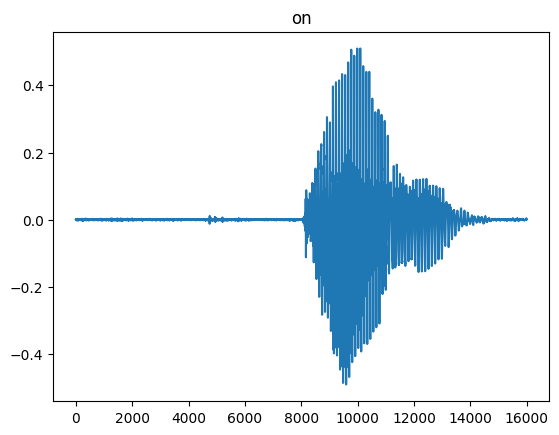

In [12]:
random_audio = get_random_audio_file(test_dir)
show_sample(random_audio)

## Define the model


When using Model Maker to retrain any model, you have to start by defining a model spec. The spec defines the base model from which your new model will extract feature embeddings to begin learning new classes. The spec for this speech recognizer is based on the pre-trained [BrowserFft model from TFJS](https://github.com/tensorflow/tfjs-models/tree/master/speech-commands#speech-command-recognizer).

The model expects input as an audio sample that's 44.1 kHz, and just under a second long: the exact sample length must be 44034 frames.

You don't need to do any resampling with your training dataset. Model Maker takes care of that for you. But when you later run inference, you must be sure that your input matches that expected format.

All you need to do here is instantiate the [`BrowserFftSpec`](https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker/audio_classifier/BrowserFftSpec):


In [13]:
spec = audio_classifier.BrowserFftSpec()

INFO:tensorflow:Checkpoints are stored in /tmpfs/tmp/tmp61i17piu


16384/18467 [=========================>....] - ETA: 0s

24576/18467 [=======================================] - 0s 0us/step


32768/18467 [=====================================================] - 0s 0us/step


16384/203 [=============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

16384/5466 [=========================================================================================] - 0s 0us/step


  16384/4194304 [..............................] - ETA: 0s

4194304/4194304 [==============================] - 0s 0us/step


4202496/4194304 [==============================] - 0s 0us/step


  16384/1680432 [..............................] - ETA: 0s

1687552/1680432 [==============================] - 0s 0us/step


1695744/1680432 [==============================] - 0s 0us/step


## Load your dataset 

Now you need to load your dataset according to the model specifications. Model Maker includes the [`DataLoader`](https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker/audio_classifier/DataLoader) API, which will load your dataset from a folder and ensure it's in the expected format for the model spec.

We already reserved some test files by moving them to a separate directory, which makes it easier to run inference with them later. Now we'll create a `DataLoader` for each split: the training set, the validation set, and the test set.

#### Load the speech commands dataset


In [14]:
if not use_custom_dataset:
  train_data_ratio = 0.8
  train_data = audio_classifier.DataLoader.from_folder(
      spec, dataset_dir, cache=True)
  train_data, validation_data = train_data.split(train_data_ratio)
  test_data = audio_classifier.DataLoader.from_folder(
      spec, test_dir, cache=True)

#### Load a custom dataset

**Note:** Setting `cache=True` is important to make training faster (especially when the dataset must be re-sampled) but it will also require more RAM to hold the data. If you use a very large custom dataset, caching might exceed your RAM capacity.

In [15]:
if use_custom_dataset:
  train_data_ratio = 0.8
  train_data = audio_classifier.DataLoader.from_folder(
      spec, dataset_dir, cache=True)
  train_data, validation_data = train_data.split(train_data_ratio)
  test_data = audio_classifier.DataLoader.from_folder(
      spec, test_dir, cache=True)


## Train the model


Now we'll use the Model Maker [`create()`](https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker/audio_classifier/create) function to create a model based on our model spec and training dataset, and begin training.

If you're using a custom dataset, you might want to change the batch size as appropriate for the number of samples in your train set.

**Note:** The first epoch takes longer because it must create the cache. 

In [16]:
# If your dataset has fewer than 100 samples per class,
# you might want to try a smaller batch size
batch_size = 25
epochs = 25
model = audio_classifier.create(train_data, spec, validation_data, batch_size, epochs)

Model: "sequential_1"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 conv2d_1 (Conv2D)           (None, 42, 225, 8)        136       


 max_pooling2d_1 (MaxPooling  (None, 21, 112, 8)       0         


 2D)                                                             


 conv2d_2 (Conv2D)           (None, 20, 109, 32)       2080      


 max_pooling2d_2 (MaxPooling  (None, 10, 54, 32)       0         


 2D)                                                             


 conv2d_3 (Conv2D)           (None, 9, 51, 32)         8224      


 max_pooling2d_3 (MaxPooling  (None, 4, 25, 32)        0         


 2D)                                                             


 conv2d_4 (Conv2D)           (None, 3, 22, 32)         8224      


 max_pooling2d_4 (MaxPooling  (None, 2, 11, 32)        0         


 2D)                                                             


 flatten_1 (Flatten)         (None, 704)               0         


 dropout_1 (Dropout)         (None, 704)               0         


 dense_1 (Dense)             (None, 2000)              1410000   


 dropout_2 (Dropout)         (None, 2000)              0         


 classification_head (Dense)  (None, 9)                18009     


Total params: 1,446,673


Trainable params: 18,009


Non-trainable params: 1,428,664


_________________________________________________________________


Epoch 1/25


      1/Unknown - 49s 49s/step - loss: 4.5810 - acc: 0.0800

      3/Unknown - 49s 142ms/step - loss: 4.1542 - acc: 0.1333

      4/Unknown - 50s 197ms/step - loss: 4.1120 - acc: 0.1500

      5/Unknown - 50s 225ms/step - loss: 4.2615 - acc: 0.1760

      6/Unknown - 50s 240ms/step - loss: 4.0187 - acc: 0.1867

      7/Unknown - 51s 252ms/step - loss: 4.0389 - acc: 0.1886

      8/Unknown - 51s 259ms/step - loss: 3.9593 - acc: 0.1900

      9/Unknown - 51s 265ms/step - loss: 3.7644 - acc: 0.2267

     10/Unknown - 52s 271ms/step - loss: 3.6832 - acc: 0.2280

     11/Unknown - 52s 275ms/step - loss: 3.7381 - acc: 0.2364

     12/Unknown - 52s 279ms/step - loss: 3.6731 - acc: 0.2467

     13/Unknown - 53s 282ms/step - loss: 3.5578 - acc: 0.2492

     14/Unknown - 53s 284ms/step - loss: 3.4438 - acc: 0.2571

     15/Unknown - 53s 285ms/step - loss: 3.3256 - acc: 0.2880

     16/Unknown - 53s 286ms/step - loss: 3.2508 - acc: 0.2950

     17/Unknown - 54s 288ms/step - loss: 3.1653 - acc: 0.3082

     18/Unknown - 54s 289ms/step - loss: 3.0676 - acc: 0.3244

     19/Unknown - 54s 290ms/step - loss: 3.0226 - acc: 0.3263

     20/Unknown - 55s 291ms/step - loss: 2.9764 - acc: 0.3280

     21/Unknown - 55s 292ms/step - loss: 2.9073 - acc: 0.3390

     22/Unknown - 55s 292ms/step - loss: 2.8253 - acc: 0.3564

     23/Unknown - 56s 293ms/step - loss: 2.7546 - acc: 0.3722

     24/Unknown - 56s 293ms/step - loss: 2.6995 - acc: 0.3750

     25/Unknown - 56s 294ms/step - loss: 2.6367 - acc: 0.3824

     26/Unknown - 56s 294ms/step - loss: 2.5969 - acc: 0.3877

     27/Unknown - 57s 295ms/step - loss: 2.5615 - acc: 0.3970

     28/Unknown - 57s 295ms/step - loss: 2.5212 - acc: 0.4057

     29/Unknown - 57s 296ms/step - loss: 2.4936 - acc: 0.4110

     30/Unknown - 58s 296ms/step - loss: 2.4357 - acc: 0.4213

     31/Unknown - 58s 296ms/step - loss: 2.3972 - acc: 0.4310

     32/Unknown - 58s 297ms/step - loss: 2.3510 - acc: 0.4425

     33/Unknown - 59s 297ms/step - loss: 2.3085 - acc: 0.4497

     34/Unknown - 59s 298ms/step - loss: 2.2612 - acc: 0.4576

     35/Unknown - 59s 298ms/step - loss: 2.2352 - acc: 0.4617

     36/Unknown - 60s 298ms/step - loss: 2.2003 - acc: 0.4689

     37/Unknown - 60s 292ms/step - loss: 2.1550 - acc: 0.4768

40/40 [==============================] - 62s 331ms/step - loss: 2.0855 - acc: 0.4893 - val_loss: 0.4560 - val_acc: 0.8606


Epoch 2/25


 1/40 [..............................] - ETA: 1s - loss: 1.3336 - acc: 0.7200

17/40 [===========>..................] - ETA: 0s - loss: 0.7177 - acc: 0.8141

33/40 [=======================>......] - ETA: 0s - loss: 0.7030 - acc: 0.7964

40/40 [==============================] - 0s 9ms/step - loss: 0.6802 - acc: 0.7961 - val_loss: 0.3246 - val_acc: 0.9124


Epoch 3/25


 1/40 [..............................] - ETA: 1s - loss: 0.8162 - acc: 0.8000

17/40 [===========>..................] - ETA: 0s - loss: 0.5051 - acc: 0.8400

33/40 [=======================>......] - ETA: 0s - loss: 0.4633 - acc: 0.8497

40/40 [==============================] - 0s 9ms/step - loss: 0.4643 - acc: 0.8481 - val_loss: 0.2713 - val_acc: 0.9363


Epoch 4/25


 1/40 [..............................] - ETA: 1s - loss: 0.4554 - acc: 0.8400

17/40 [===========>..................] - ETA: 0s - loss: 0.3835 - acc: 0.8894

33/40 [=======================>......] - ETA: 0s - loss: 0.4241 - acc: 0.8812

40/40 [==============================] - 0s 9ms/step - loss: 0.4172 - acc: 0.8828 - val_loss: 0.2559 - val_acc: 0.9402


Epoch 5/25


 1/40 [..............................] - ETA: 1s - loss: 0.2811 - acc: 0.8800

17/40 [===========>..................] - ETA: 0s - loss: 0.3466 - acc: 0.8800

33/40 [=======================>......] - ETA: 0s - loss: 0.3233 - acc: 0.8921

40/40 [==============================] - 0s 9ms/step - loss: 0.3187 - acc: 0.8919 - val_loss: 0.2312 - val_acc: 0.9442


Epoch 6/25


 1/40 [..............................] - ETA: 1s - loss: 0.0342 - acc: 1.0000

17/40 [===========>..................] - ETA: 0s - loss: 0.2438 - acc: 0.9271

33/40 [=======================>......] - ETA: 0s - loss: 0.2462 - acc: 0.9224

40/40 [==============================] - 0s 9ms/step - loss: 0.2508 - acc: 0.9246 - val_loss: 0.2253 - val_acc: 0.9482


Epoch 7/25


 1/40 [..............................] - ETA: 1s - loss: 0.0735 - acc: 1.0000

17/40 [===========>..................] - ETA: 0s - loss: 0.2240 - acc: 0.9388

33/40 [=======================>......] - ETA: 0s - loss: 0.2481 - acc: 0.9285

40/40 [==============================] - 0s 8ms/step - loss: 0.2466 - acc: 0.9297 - val_loss: 0.2411 - val_acc: 0.9482


Epoch 8/25


 1/40 [..............................] - ETA: 1s - loss: 0.1038 - acc: 0.9200

17/40 [===========>..................] - ETA: 0s - loss: 0.2355 - acc: 0.9271

34/40 [========================>.....] - ETA: 0s - loss: 0.2177 - acc: 0.9318

40/40 [==============================] - 0s 9ms/step - loss: 0.2265 - acc: 0.9307 - val_loss: 0.2299 - val_acc: 0.9323


Epoch 9/25


 1/40 [..............................] - ETA: 1s - loss: 0.2054 - acc: 0.8800

17/40 [===========>..................] - ETA: 0s - loss: 0.1647 - acc: 0.9459

33/40 [=======================>......] - ETA: 0s - loss: 0.2004 - acc: 0.9321

40/40 [==============================] - 0s 8ms/step - loss: 0.2007 - acc: 0.9276 - val_loss: 0.2202 - val_acc: 0.9402


Epoch 10/25


 1/40 [..............................] - ETA: 1s - loss: 0.3196 - acc: 0.9600

17/40 [===========>..................] - ETA: 0s - loss: 0.1770 - acc: 0.9506

34/40 [========================>.....] - ETA: 0s - loss: 0.1838 - acc: 0.9482

40/40 [==============================] - 0s 9ms/step - loss: 0.1803 - acc: 0.9480 - val_loss: 0.2284 - val_acc: 0.9363


Epoch 11/25


 1/40 [..............................] - ETA: 1s - loss: 0.2196 - acc: 0.9200

17/40 [===========>..................] - ETA: 0s - loss: 0.1432 - acc: 0.9412

33/40 [=======================>......] - ETA: 0s - loss: 0.1730 - acc: 0.9382

40/40 [==============================] - 0s 9ms/step - loss: 0.1616 - acc: 0.9429 - val_loss: 0.2239 - val_acc: 0.9442


Epoch 12/25


 1/40 [..............................] - ETA: 1s - loss: 0.0480 - acc: 1.0000

17/40 [===========>..................] - ETA: 0s - loss: 0.1405 - acc: 0.9506

33/40 [=======================>......] - ETA: 0s - loss: 0.1473 - acc: 0.9491

40/40 [==============================] - 0s 9ms/step - loss: 0.1418 - acc: 0.9501 - val_loss: 0.2051 - val_acc: 0.9482


Epoch 13/25


 1/40 [..............................] - ETA: 1s - loss: 0.1100 - acc: 0.9600

18/40 [============>.................] - ETA: 0s - loss: 0.1365 - acc: 0.9578

35/40 [=========================>....] - ETA: 0s - loss: 0.1479 - acc: 0.9531

40/40 [==============================] - 0s 9ms/step - loss: 0.1419 - acc: 0.9531 - val_loss: 0.2223 - val_acc: 0.9363


Epoch 14/25


 1/40 [..............................] - ETA: 1s - loss: 0.1848 - acc: 0.8800

17/40 [===========>..................] - ETA: 0s - loss: 0.1139 - acc: 0.9600

33/40 [=======================>......] - ETA: 0s - loss: 0.0973 - acc: 0.9648

40/40 [==============================] - 0s 9ms/step - loss: 0.1024 - acc: 0.9633 - val_loss: 0.2248 - val_acc: 0.9442


Epoch 15/25


 1/40 [..............................] - ETA: 1s - loss: 0.1110 - acc: 0.9200

17/40 [===========>..................] - ETA: 0s - loss: 0.0954 - acc: 0.9694

33/40 [=======================>......] - ETA: 0s - loss: 0.1083 - acc: 0.9673

40/40 [==============================] - 0s 9ms/step - loss: 0.1052 - acc: 0.9694 - val_loss: 0.2269 - val_acc: 0.9402


Epoch 16/25


 1/40 [..............................] - ETA: 1s - loss: 0.0716 - acc: 0.9600

17/40 [===========>..................] - ETA: 0s - loss: 0.0994 - acc: 0.9694

33/40 [=======================>......] - ETA: 0s - loss: 0.1001 - acc: 0.9685

40/40 [==============================] - 0s 9ms/step - loss: 0.0995 - acc: 0.9684 - val_loss: 0.2213 - val_acc: 0.9442


Epoch 17/25


 1/40 [..............................] - ETA: 1s - loss: 0.1588 - acc: 0.9600

18/40 [============>.................] - ETA: 0s - loss: 0.1103 - acc: 0.9644

34/40 [========================>.....] - ETA: 0s - loss: 0.1152 - acc: 0.9624

40/40 [==============================] - 0s 9ms/step - loss: 0.1064 - acc: 0.9664 - val_loss: 0.2426 - val_acc: 0.9442


Epoch 18/25


 1/40 [..............................] - ETA: 1s - loss: 0.0562 - acc: 0.9600

17/40 [===========>..................] - ETA: 0s - loss: 0.0885 - acc: 0.9694

34/40 [========================>.....] - ETA: 0s - loss: 0.1110 - acc: 0.9600

40/40 [==============================] - 0s 9ms/step - loss: 0.1132 - acc: 0.9613 - val_loss: 0.2276 - val_acc: 0.9402


Epoch 19/25


 1/40 [..............................] - ETA: 1s - loss: 0.0834 - acc: 0.9600

17/40 [===========>..................] - ETA: 0s - loss: 0.0636 - acc: 0.9741

33/40 [=======================>......] - ETA: 0s - loss: 0.1102 - acc: 0.9588

40/40 [==============================] - 0s 9ms/step - loss: 0.1030 - acc: 0.9613 - val_loss: 0.2101 - val_acc: 0.9402


Epoch 20/25


 1/40 [..............................] - ETA: 1s - loss: 0.1361 - acc: 0.9600

17/40 [===========>..................] - ETA: 0s - loss: 0.0671 - acc: 0.9788

33/40 [=======================>......] - ETA: 0s - loss: 0.0697 - acc: 0.9745

40/40 [==============================] - 0s 9ms/step - loss: 0.0857 - acc: 0.9684 - val_loss: 0.2011 - val_acc: 0.9442


Epoch 21/25


 1/40 [..............................] - ETA: 1s - loss: 0.0377 - acc: 1.0000

17/40 [===========>..................] - ETA: 0s - loss: 0.0805 - acc: 0.9694

33/40 [=======================>......] - ETA: 0s - loss: 0.0845 - acc: 0.9673

40/40 [==============================] - 0s 9ms/step - loss: 0.0899 - acc: 0.9643 - val_loss: 0.2054 - val_acc: 0.9402


Epoch 22/25


 1/40 [..............................] - ETA: 1s - loss: 0.0613 - acc: 0.9600

17/40 [===========>..................] - ETA: 0s - loss: 0.0590 - acc: 0.9765

33/40 [=======================>......] - ETA: 0s - loss: 0.0668 - acc: 0.9758

40/40 [==============================] - 0s 9ms/step - loss: 0.0633 - acc: 0.9766 - val_loss: 0.2066 - val_acc: 0.9402


Epoch 23/25


 1/40 [..............................] - ETA: 1s - loss: 0.1317 - acc: 0.9600

17/40 [===========>..................] - ETA: 0s - loss: 0.0485 - acc: 0.9882

34/40 [========================>.....] - ETA: 0s - loss: 0.0635 - acc: 0.9812

40/40 [==============================] - 0s 8ms/step - loss: 0.0639 - acc: 0.9817 - val_loss: 0.2049 - val_acc: 0.9482


Epoch 24/25


 1/40 [..............................] - ETA: 1s - loss: 0.0013 - acc: 1.0000

17/40 [===========>..................] - ETA: 0s - loss: 0.0495 - acc: 0.9835

34/40 [========================>.....] - ETA: 0s - loss: 0.0595 - acc: 0.9776

40/40 [==============================] - 0s 9ms/step - loss: 0.0668 - acc: 0.9766 - val_loss: 0.1932 - val_acc: 0.9482


Epoch 25/25


 1/40 [..............................] - ETA: 1s - loss: 0.0735 - acc: 0.9600

17/40 [===========>..................] - ETA: 0s - loss: 0.0451 - acc: 0.9882

33/40 [=======================>......] - ETA: 0s - loss: 0.0677 - acc: 0.9806

40/40 [==============================] - 0s 9ms/step - loss: 0.0641 - acc: 0.9827 - val_loss: 0.1971 - val_acc: 0.9442


## Review the model performance

Even if the accuracy/loss looks good from the training output above, it's important to also run the model using test data that the model has not seen yet, which is what the `evaluate()` method does here:

In [17]:
model.evaluate(test_data)

      1/Unknown - 1s 705ms/step - loss: 0.2065 - acc: 0.9375

      2/Unknown - 1s 100ms/step - loss: 0.3577 - acc: 0.9062

      3/Unknown - 1s 128ms/step - loss: 0.2467 - acc: 0.9375

      4/Unknown - 1s 137ms/step - loss: 0.3331 - acc: 0.8984

      5/Unknown - 1s 146ms/step - loss: 0.3329 - acc: 0.9062

      6/Unknown - 1s 151ms/step - loss: 0.2899 - acc: 0.9167

      7/Unknown - 2s 157ms/step - loss: 0.3020 - acc: 0.9152

      8/Unknown - 2s 146ms/step - loss: 0.2912 - acc: 0.9156

8/8 [==============================] - 2s 149ms/step - loss: 0.2912 - acc: 0.9156


[0.2911592125892639, 0.9156118035316467]

### View the confusion matrix

When training a classification model such as this one, it's also useful to inspect the [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix). The confusion matrix gives you detailed visual representation of how well your classifier performs for each classification in your test data.

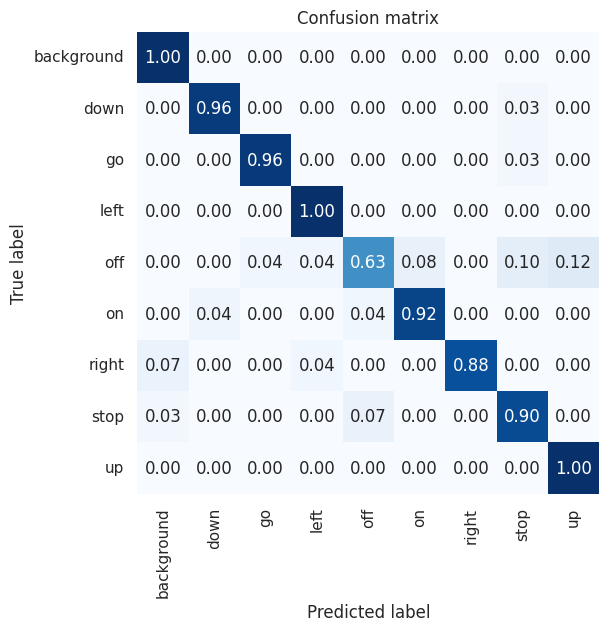

In [18]:
def show_confusion_matrix(confusion, test_labels):
  """Compute confusion matrix and normalize."""
  confusion_normalized = confusion.astype("float") / confusion.sum(axis=1)
  sns.set(rc = {'figure.figsize':(6,6)})
  sns.heatmap(
      confusion_normalized, xticklabels=test_labels, yticklabels=test_labels,
      cmap='Blues', annot=True, fmt='.2f', square=True, cbar=False)
  plt.title("Confusion matrix")
  plt.ylabel("True label")
  plt.xlabel("Predicted label")

confusion_matrix = model.confusion_matrix(test_data)
show_confusion_matrix(confusion_matrix.numpy(), test_data.index_to_label)

## Export the model

The last step is exporting your model into the TensorFlow Lite format for execution on mobile/embedded devices and into the [SavedModel format](https://www.tensorflow.org/guide/saved_model) for execution elsewhere.

When exporting a `.tflite` file from Model Maker, it includes [model metadata](https://www.tensorflow.org/lite/inference_with_metadata/overview) that describes various details that can later help during inference. It even includes a copy of the classification labels file, so you don't need to a separate `labels.txt` file. (In the next section, we show how to use this metadata to run an inference.)

In [19]:
TFLITE_FILENAME = 'browserfft-speech.tflite'
SAVE_PATH = './models'

In [20]:
print(f'Exporing the model to {SAVE_PATH}')
model.export(SAVE_PATH, tflite_filename=TFLITE_FILENAME)
model.export(SAVE_PATH, export_format=[mm.ExportFormat.SAVED_MODEL, mm.ExportFormat.LABEL])

Exporing the model to ./models


2022-10-20 11:20:21.323243: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /tmpfs/tmp/tmp__zipkr0/assets


INFO:tensorflow:TensorFlow Lite model exported successfully: ./models/browserfft-speech.tflite


2022-10-20 11:20:23.370245: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2022-10-20 11:20:23.370303: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
INFO:tensorflow:TensorFlow Lite model exported successfully: ./models/browserfft-speech.tflite


INFO:tensorflow:Assets written to: ./models/saved_model/assets


INFO:tensorflow:Assets written to: ./models/saved_model/assets


INFO:tensorflow:Saving labels in ./models/labels.txt


INFO:tensorflow:Saving labels in ./models/labels.txt


## Run inference with TF Lite model

Now your TFLite model can be deployed and run using any of the supported [inferencing libraries](https://www.tensorflow.org/lite/guide/inference) or with the new [TFLite AudioClassifier Task API](https://www.tensorflow.org/lite/inference_with_metadata/task_library/audio_classifier). The following code shows how you can run inference with the `.tflite` model in Python.

In [21]:
# This library provides the TFLite metadata API
! pip install -q tflite_support

In [22]:
from tflite_support import metadata
import json

def get_labels(model):
  """Returns a list of labels, extracted from the model metadata."""
  displayer = metadata.MetadataDisplayer.with_model_file(model)
  labels_file = displayer.get_packed_associated_file_list()[0]
  labels = displayer.get_associated_file_buffer(labels_file).decode()
  return [line for line in labels.split('\n')]

def get_input_sample_rate(model):
  """Returns the model's expected sample rate, from the model metadata."""
  displayer = metadata.MetadataDisplayer.with_model_file(model)
  metadata_json = json.loads(displayer.get_metadata_json())
  input_tensor_metadata = metadata_json['subgraph_metadata'][0][
          'input_tensor_metadata'][0]
  input_content_props = input_tensor_metadata['content']['content_properties']
  return input_content_props['sample_rate']

To observe how well the model performs with real samples, run the following code block over and over. Each time, it will fetch a new test sample and run inference with it, and you can listen to the audio sample below.

---prediction---
Class: background
Score: 0.9910123944282532
----truth----
Class: background
File: /tmpfs/src/temp/tensorflow/lite/g3doc/models/modify/model_maker/dataset-test/background/pink_noise7.wav
Sample rate: 16000
Sample length: 16000


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


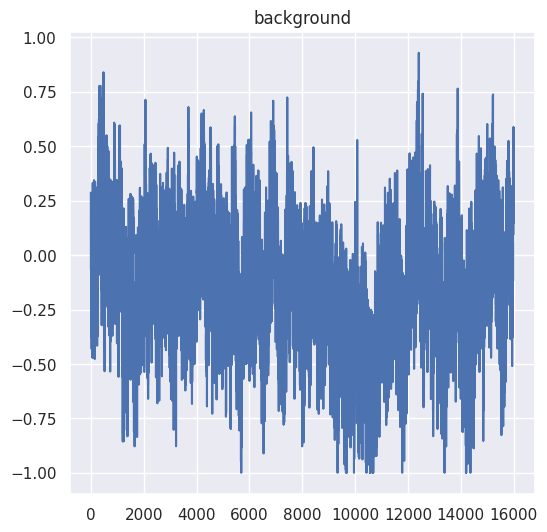

In [23]:
# Get a WAV file for inference and list of labels from the model
tflite_file = os.path.join(SAVE_PATH, TFLITE_FILENAME)
labels = get_labels(tflite_file)
random_audio = get_random_audio_file(test_dir)

# Ensure the audio sample fits the model input
interpreter = tf.lite.Interpreter(tflite_file)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
input_size = input_details[0]['shape'][1]
sample_rate = get_input_sample_rate(tflite_file)
audio_data, _ = librosa.load(random_audio, sr=sample_rate)
if len(audio_data) < input_size:
  audio_data.resize(input_size)
audio_data = np.expand_dims(audio_data[:input_size], axis=0)

# Run inference
interpreter.allocate_tensors()
interpreter.set_tensor(input_details[0]['index'], audio_data)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])

# Display prediction and ground truth
top_index = np.argmax(output_data[0])
label = labels[top_index]
score = output_data[0][top_index]
print('---prediction---')
print(f'Class: {label}\nScore: {score}')
print('----truth----')
show_sample(random_audio)

## Download the TF Lite model

Now you can deploy the TF Lite model to your mobile or embedded device. You don't need to download the labels file because you can instead retrieve the labels from `.tflite` file metadata, as shown in the previous inferencing example.

In [24]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download(tflite_file)

Check out our end-to-end example apps that perform inferencing with TFLite audio models on [Android](https://github.com/tensorflow/examples/tree/master/lite/examples/sound_classification/android/) and [iOS](https://github.com/tensorflow/examples/tree/master/lite/examples/sound_classification/ios).